## Detect fake profiles in online social networks using Support Vector Machine

In [34]:
import sys
import csv
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
!pip install gender-guesser
import gender_guesser.detector as gender
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_validate,cross_val_score
#from sklearn.model_selection import 
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from  sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc ,roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
%matplotlib inline 

In [2]:
def read_datasets():
    #Reads users profile from csv files """
    genuine_users = pd.read_csv("users.csv")
    fake_users = pd.read_csv("fusers.csv")
    # print genuine_users.columns
    # print genuine_users.describe()
    #print fake_users.describe()
    x=pd.concat([genuine_users,fake_users])
    y=len(fake_users)*[0] + len(genuine_users)*[1]
    return x,y

In [21]:
def predict_sex(name):
    sex_predictor = gender.Detector(case_sensitive=False)
    first_name= name.str.split(' ').str.get(0)
    sex= first_name.apply(sex_predictor.get_gender)
    sex_dict={'female': -2, 'mostly_female': -1,'unknown':0,'mostly_male':1, 'male': 2}
    sex_code = sex.map(sex_dict).fillna(0)
    sex_code = sex_code.astype(float)
    return sex_code

In [22]:
def extract_features(x):
    lang_list = list(enumerate(np.unique(x['lang'])))   
    lang_dict = { name : i for i, name in lang_list }             
    x.loc[:,'lang_code'] = x['lang'].map( lambda x: lang_dict[x]).astype(int)    
    x.loc[:,'sex_code']=predict_sex(x['name'])
    feature_columns_to_use = ['statuses_count','followers_count','friends_count','favourites_count','listed_count','sex_code','lang_code']
    x=x.loc[:,feature_columns_to_use]
    return x

In [23]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
            plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1,color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
    label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
    plt.legend(loc="best")
    return plt

In [24]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    target_names=['Fake','Genuine']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
def plot_roc_curve(y_test, y_pred):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    print ("False Positive rate: ",false_positive_rate)
    print ("True Positive rate: ",true_positive_rate)
    
    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [42]:
def train(X_train,y_train,X_test):
    """ Trains and predicts dataset with a SVM classifier """
    # Scaling features
    X_train=preprocessing.scale(X_train)
    X_test=preprocessing.scale(X_test)

    Cs = 10.0 ** np.arange(-2,3,.5)
    gammas = 10.0 ** np.arange(-2,3,.5)
    param = [{'gamma': gammas, 'C': Cs}]
    cvk = StratifiedKFold(n_splits=5)
    classifier = SVC()
    clf = GridSearchCV(classifier,param_grid=param,cv=cvk)
    clf.fit(X_train,y_train)
    print("The best classifier is: ",clf.best_estimator_)
    clf.best_estimator_.fit(X_train,y_train)
    # Estimate score
    scores = cross_val_score(clf.best_estimator_, X_train,y_train, cv=5)
    print(scores)
    print('Estimated score: %0.5f (+/- %0.5f)' % (scores.mean(), scores.std() / 2))
    title = 'Learning Curves (SVM, rbf kernel, $\gamma=%.6f$)' %clf.best_estimator_.gamma
    plot_learning_curve(clf.best_estimator_, title, X_train, y_train, cv=5)
    plt.show()
    # Predict class
    y_pred = clf.best_estimator_.predict(X_test)
    return y_test,y_pred

In [27]:
print("reading datasets.....\n")
x,y=read_datasets()

reading datasets.....



In [28]:
print("extracting featues.....\n")
x=extract_features(x)
print(x.columns)
print(x.describe())

extracting featues.....

Index(['statuses_count', 'followers_count', 'friends_count',
       'favourites_count', 'listed_count', 'sex_code', 'lang_code'],
      dtype='object')
       statuses_count  followers_count  friends_count  favourites_count  \
count     2818.000000      2818.000000    2818.000000       2818.000000   
mean      1672.198368       371.105039     395.363023        234.541164   
std       4884.669157      8022.631339     465.694322       1445.847248   
min          0.000000         0.000000       0.000000          0.000000   
25%         35.000000        17.000000     168.000000          0.000000   
50%         77.000000        26.000000     306.000000          0.000000   
75%       1087.750000       111.000000     519.000000         37.000000   
max      79876.000000    408372.000000   12773.000000      44349.000000   

       listed_count     sex_code    lang_code  
count   2818.000000  2818.000000  2818.000000  
mean       2.818666    -0.191270     2.851313  
std

In [38]:
print("spliting datasets in train and test dataset...\n")
X_train,X_test,y_train,y_test = train_test_split(x, y, test_size=0.20, random_state=44)

spliting datasets in train and test dataset...



training datasets.......

The best classifier is:  SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=100.0, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
[0.92017738 0.92239468 0.92682927 0.9578714  0.94      ]
Estimated score: 0.93345 (+/- 0.00701)


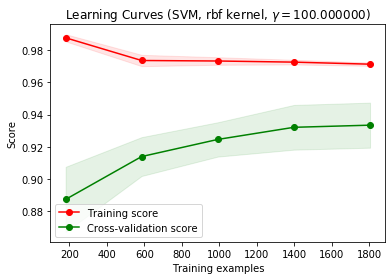

In [43]:
print("training datasets.......\n")
y_test,y_pred = train(X_train,y_train,X_test)

In [45]:
print('Classification Accuracy on Test dataset: ' ,accuracy_score(y_test, y_pred))

Classification Accuracy on Test dataset:  0.898936170212766


Confusion matrix, without normalization
[[264   4]
 [ 53 243]]


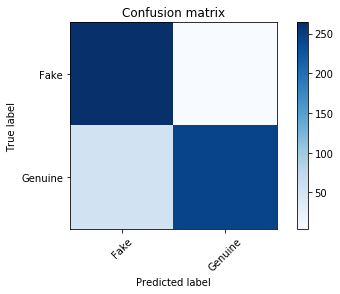

In [46]:
cm=confusion_matrix(y_test, y_pred)
print('Confusion matrix, without normalization')
print(cm)
plot_confusion_matrix(cm)

Normalized confusion matrix
[[0.98507463 0.01492537]
 [0.17905405 0.82094595]]


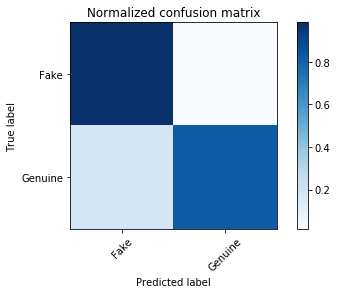

In [47]:
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

In [48]:
print(classification_report(y_test, y_pred, target_names=['Fake','Genuine']))

              precision    recall  f1-score   support

        Fake       0.83      0.99      0.90       268
     Genuine       0.98      0.82      0.90       296

    accuracy                           0.90       564
   macro avg       0.91      0.90      0.90       564
weighted avg       0.91      0.90      0.90       564



False Positive rate:  [0.         0.01492537 1.        ]
True Positive rate:  [0.         0.82094595 1.        ]


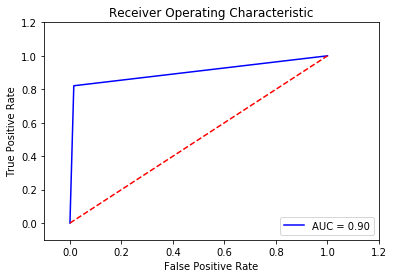

In [49]:
plot_roc_curve(y_test, y_pred)